# COMP3602 – HW3  
Shahad Aljahwari-133011
## 1. Data Acquisition & Review


This section presents an initial review of the energy consumption dataset,
including dataset size, attributes, missing values, and summary statistics.


In [2]:
# === HW3 - Part 1: Data Acquisition & Review ===
import pandas as pd

# 1) Read dataset into df
df = pd.read_csv("/content/energy_consumption (1).csv")

# 2) Display dataset size
print("Dataset size (rows, cols):", df.shape)

# 3) Display attributes (names/types)
print("\nAttributes (name -> dtype):")
print(df.dtypes)

# 4) Sum of missing values for each attribute
print("\nMissing values per column:")
print(df.isna().sum())

# 5) Summary statistics (numeric + object)
print("\nSummary statistics (numeric):")
print(df.describe())

print("\nSummary statistics (including non-numeric):")
print(df.describe(include="all"))


Dataset size (rows, cols): (168, 4)

Attributes (name -> dtype):
Date           object
Energy_kWh    float64
Month           int64
Season         object
dtype: object

Missing values per column:
Date          0
Energy_kWh    4
Month         0
Season        0
dtype: int64

Summary statistics (numeric):
       Energy_kWh  Month
count  164.000000  168.0
mean   400.256404    1.0
std     41.843839    0.0
min    316.723332    1.0
25%    365.785060    1.0
50%    397.829083    1.0
75%    432.458053    1.0
max    490.921384    1.0

Summary statistics (including non-numeric):
                 Date  Energy_kWh  Month  Season
count             168  164.000000  168.0     168
unique            168         NaN    NaN       2
top     1/2/2018 7:00         NaN    NaN  Summer
freq                1         NaN    NaN     107
mean              NaN  400.256404    1.0     NaN
std               NaN   41.843839    0.0     NaN
min               NaN  316.723332    1.0     NaN
25%               NaN  365.785060  

The dataset contains 168 rows and 4 columns.
Energy_kWh includes a small number of missing values, while other attributes are complete.
The summary statistics show that energy consumption has moderate variation across time.


## 2. Data Cleaning and Preprocessing

This section handles missing values, converts categorical variables,
and prepares the dataset for time series analysis.


In [4]:
from sklearn.preprocessing import LabelEncoder

df_clean = df.copy()

df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.sort_values("Date")
df_clean.set_index("Date", inplace=True)

df_clean["Energy_kWh"] = df_clean["Energy_kWh"].fillna(df_clean["Energy_kWh"].mean())

le = LabelEncoder()
df_clean["Season"] = le.fit_transform(df_clean["Season"])

df_clean.describe(include="all")



,Energy_kWh,Month,Season
count,168.000000,168.0,168.000000
mean,400.256404,1.0,0.363095
std,41.339678,0.0,0.482330
min,316.723332,1.0,0.000000
25%,366.135527,1.0,0.000000
50%,399.443309,1.0,0.000000
75%,432.375520,1.0,1.000000
max,490.921384,1.0,1.000000


The dataset was successfully cleaned and prepared for time series analysis.
Missing values in Energy_kWh were imputed using the mean, preserving the data distribution.
The Date column was converted to datetime and set as the index to ensure correct temporal order.
Categorical Season values were encoded numerically, making the dataset ready for modeling.

Label Encoding was used for the Season attribute because it is a binary
categorical variable (e.g., Summer and Winter). Since there is no true
ordinal relationship between the categories, using label encoding does
not introduce misleading ordering and is suitable for this case.


## 3. Time Series Exploration & Visualization


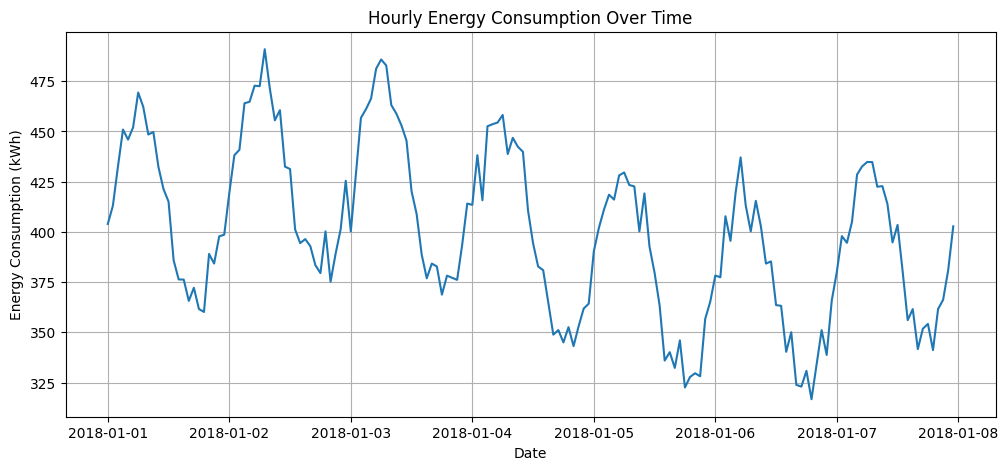

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_clean.index, df_clean["Energy_kWh"])
plt.title("Hourly Energy Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.grid(True)
plt.show()


The hourly energy consumption time series shows clear fluctuations over time.
There is a repeating pattern that suggests seasonal or cyclical behavior.
The mean of the series does not appear constant, indicating that the data
is likely non-stationary. Therefore, further analysis such as differencing
is required before applying ARIMA modeling.


<Figure size 1000x400 with 0 Axes>

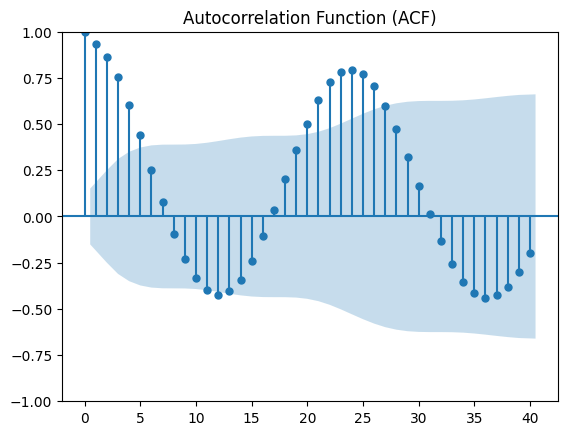

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(df_clean["Energy_kWh"], lags=40)
plt.title("Autocorrelation Function (ACF)")
plt.show()


The ACF plot shows strong positive autocorrelation at small lags, which
gradually decreases rather than cutting off sharply.
This behavior indicates that the time series is not stationary and
exhibits temporal dependence between observations.

The presence of multiple significant lags suggests that the series
contains structured patterns, supporting the need for differencing
before ARIMA modeling.


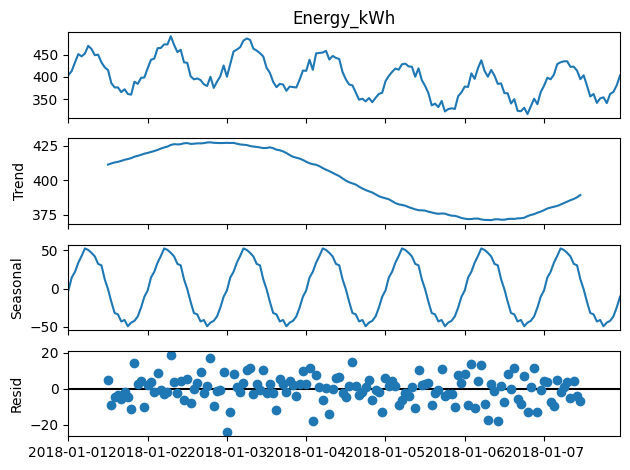

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    df_clean["Energy_kWh"],
    model="additive",
    period=24
)

decomposition.plot()
plt.show()


The decomposition of the time series reveals a clear trend and seasonal pattern.
The trend component shows a gradual decrease in energy consumption followed by
a slight increase toward the end of the series.

The seasonal component displays a strong and repeating daily pattern,
indicating regular hourly fluctuations in energy usage.

The residuals appear to be randomly scattered around zero with no clear pattern,
suggesting that most of the structure in the data has been captured by the trend
and seasonal components.


ARIMA models work effectively on evenly spaced hourly time series because
they rely on consistent time intervals to capture temporal dependencies.
Hourly data ensures uniform spacing, allowing the model to accurately learn
patterns from past observations and produce reliable forecasts.


## 4. Stationarity Analysis & Model Preparation


In [8]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_clean["Energy_kWh"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -1.0107861981628845
p-value: 0.749309982004738
Critical Values:
   1%: -3.473829775724492
   5%: -2.880622899711496
   10%: -2.5769448985432954


The Augmented Dickey–Fuller (ADF) test was applied to the original time series.
The ADF statistic (-1.01) is higher than all critical values, and the p-value
(0.75) is greater than 0.05.

Therefore, the null hypothesis cannot be rejected, indicating that the
time series is non-stationary. As a result, differencing is required
before applying ARIMA modeling.


In [9]:
df_diff = df_clean["Energy_kWh"].diff().dropna()

adf_diff = adfuller(df_diff)

print("ADF Statistic (Differenced):", adf_diff[0])
print("p-value (Differenced):", adf_diff[1])


ADF Statistic (Differenced): -7.88838217359797
p-value (Differenced): 4.50512569340672e-12


After applying differencing, the ADF test statistic is -7.89, which is
much lower than the critical values. The p-value is very small (4.51e-12),
indicating that the null hypothesis can be rejected.

This confirms that the time series is now stationary, and we can proceed with
ARIMA modeling.


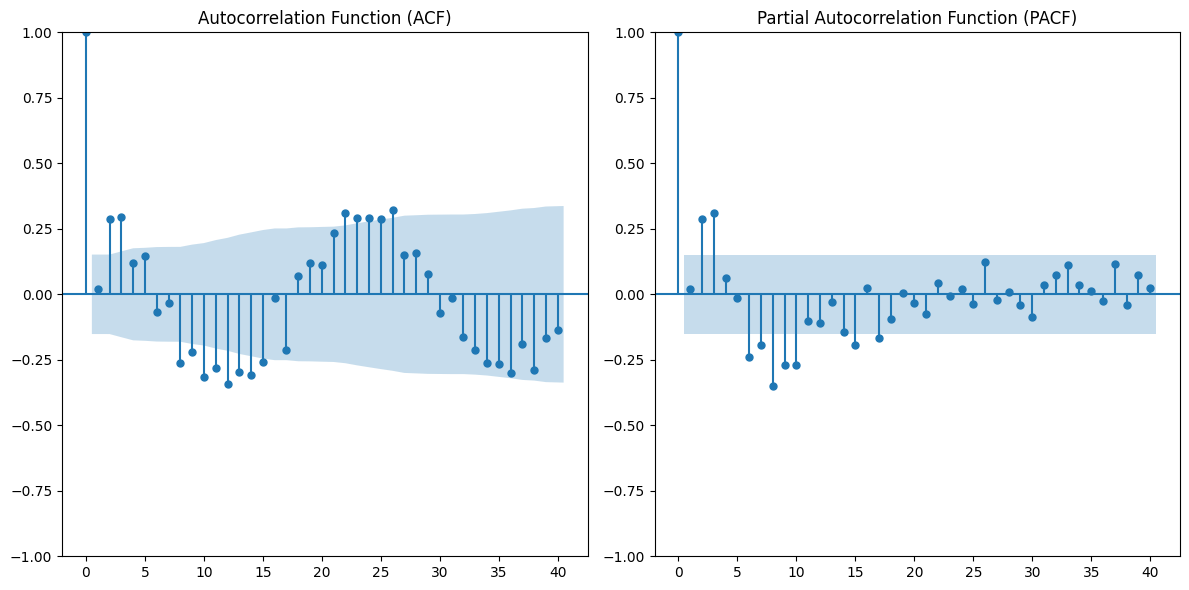

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=40, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()


Based on the ACF and PACF plots of the differenced series, the PACF shows a
significant spike at lag 1 and then cuts off, suggesting an autoregressive
order p = 1. The ACF shows a significant spike at lag 1 followed by a gradual
decline, indicating a moving average order q = 1.

Since one differencing step was required to achieve stationarity, d = 1.
Therefore, the selected model is ARIMA(1, 1, 1).


In [12]:
from statsmodels.tsa.arima.model import ARIMA

train = df_clean["Energy_kWh"][:int(0.8 * len(df_clean))]
test = df_clean["Energy_kWh"][int(0.8 * len(df_clean)):]

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:             Energy_kWh   No. Observations:                  134
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -546.940
Date:                Sun, 14 Dec 2025   AIC                           1099.881
Time:                        14:52:01   BIC                           1108.552
Sample:                    01-01-2018   HQIC                          1103.404
                         - 01-06-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7721      0.211      3.666      0.000       0.359       1.185
ma.L1         -0.6271      0.253     -2.479      0.013      -1.123      -0.131
sigma2       218.3706     31.281      6.981      0.0

The ARIMA(1,1,1) model was successfully trained on the training dataset.
Both AR and MA coefficients are statistically significant, as their p-values
are less than 0.05, indicating that the model parameters contribute meaningfully
to the prediction.

The AIC value of 1099.88 suggests a reasonable model fit, and the Ljung-Box test
shows no strong evidence of remaining autocorrelation in the residuals.
Overall, the model is suitable for forecasting hourly energy consumption.

In addition to AIC, the BIC value was also considered. The relatively low
BIC indicates that the model achieves a good balance between goodness of
fit and model complexity, supporting the suitability of the selected
ARIMA(1,1,1) model.


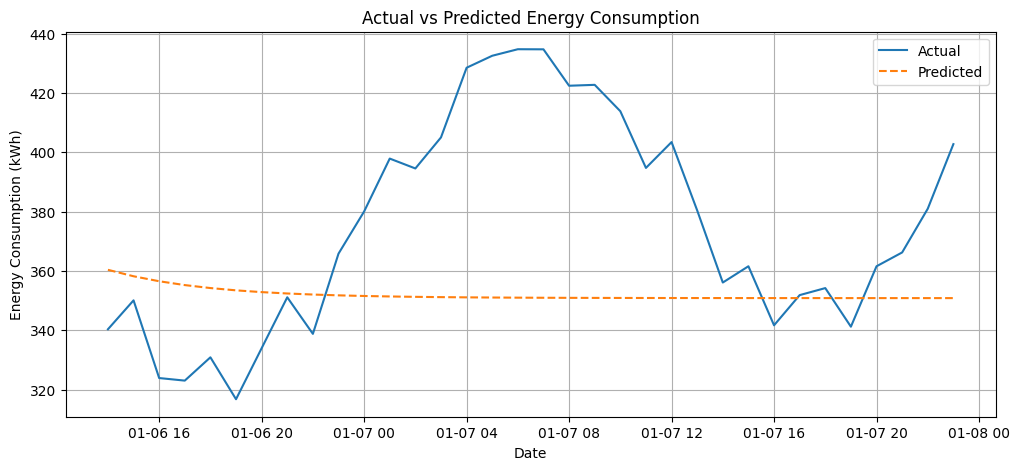

In [13]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.show()


The comparison between actual and predicted values shows that the ARIMA(1,1,1)
model captures the overall level of energy consumption but does not fully
capture short-term fluctuations.

The predicted values appear smoother than the actual series, which is expected
for ARIMA models. While the model follows the general trend, deviations occur
during peak and low consumption periods.


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 34.690638351038814
RMSE: 43.309776566420986


The forecasting performance of the ARIMA(1,1,1) model was evaluated using
Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

The MAE value of approximately 34.7 kWh indicates the average absolute
difference between the predicted and actual energy consumption values.
The RMSE value of approximately 43.3 kWh reflects the presence of larger
errors during peak consumption periods.

Overall, the results suggest that the model provides a reasonable forecast,
though some deviation is expected due to the variability in hourly energy usage.

Compared to a simple baseline model such as using the historical mean
as a predictor, the ARIMA model provides improved forecasting performance
by capturing temporal dependencies in the data. This demonstrates the
advantage of using ARIMA over naive baseline approaches for time series
forecasting.
